# Setting boundaries on model parameters

In previous parts of the tutorial we've looked at simulation methods and performed some basic fitting.

In this notebook, we'll try to set some _boundaries_ on the parameter values we expect.
This will make our life easier in three ways:

1. By staying within a sensible region of parameter space, we can avoid numerical issues
2. By reducing the size of the search space, we can speed up optimisations and make them more robust
3. By sampling from within known boundaries we can derive random parameter sets to use as starting points for our search.

## Dealing with simulation issues in a ForwardModel

First, we'll show what can happen when you don't define boundaries.
We'll begin by defining a forward model that uses the `myokit.Simulation` class:

In [ ]:
import matplotlib.pyplot as plt
import myokit
import myokit.lib.hh
import numpy as np
import pints

class Model(pints.ForwardModel):
    """A forward model that runs simulations on step protocols."""
    
    def __init__(self, protocol):
        
        # Load a model, and isolate the HH ion current model part
        model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
        parameters = ['ikr.p' + str(1 + i) for i in range(9)]        
        hh_model = myokit.lib.hh.HHModel.from_component(model.get('ikr'), parameters=parameters)

        # Create a Simulation
        self.sim = myokit.Simulation(model, protocol)
        
        # Set the -80mV steady state as the default state
        self.sim.set_default_state(hh_model.steady_state(-80))
        
    def n_parameters(self):
        return 9
    
    def simulate(self, parameters, times):

        # Reset, apply parameters, and run
        self.sim.reset()
        
        for i, p in enumerate(parameters):
            self.sim.set_constant('ikr.p' + str(1 + i), p)

        log = self.sim.run(times[-1] + 0.1, log_times=times, log=['ikr.IKr'])
        return log['ikr.IKr']    

In [2]:
# Load a protocol and create a foward model instance
protocol = myokit.load_protocol('resources/simplified-staircase.mmt')
model = Model(protocol)

# Define a parameter vector
parameters = np.array([3e-4, 0.07, 3e-5, 0.05, 0.09, 9e-3, 5e-3, 0.03, 0.2])

# Evaluate the model
times = np.arange(0, 15400, 0.1)
values = model.simulate(parameters, times)

So far so good! Now let's try some random parameters

In [3]:
np.random.seed(5)
parameters = np.random.lognormal(0, 2, 9)
values = model.simulate(parameters, times)

SimulationError: Function CVode() failed with flag -3 CV_ERR_FAILURE: Error test failures occurred too many times during one internal time step or minimum step size was reached.

That doesn't look too good!

The `SimulationError` above tells us the ODE solver (CVODE), has either had too many "test failures", or its "minimum step size was reached".
In other words, at some point during the simulation the solver was unable to determine a step size that would lead to a good prediction for the next step.

So what can we do about it?
A first thought might be to catch the errors, and return some other output, i.e. a list of `NaN` objects:

In [4]:
class Model(pints.ForwardModel):
    """A forward model that runs simulations on step protocols."""
    
    def __init__(self, protocol):
        
        # Load a model, and isolate the HH ion current model part
        model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
        parameters = ['ikr.p' + str(1 + i) for i in range(9)]        
        hh_model = myokit.lib.hh.HHModel.from_component(model.get('ikr'), parameters=parameters)

        # Create a Simulation
        self.sim = myokit.Simulation(model, protocol)
        
        # Set the -80mV steady state as the default state
        self.sim.set_default_state(hh_model.steady_state(-80))
        
    def n_parameters(self):
        return 9
    
    def simulate(self, parameters, times):

        # Reset, apply parameters, and run
        self.sim.reset()
        
        for i, p in enumerate(parameters):
            self.sim.set_constant('ikr.p' + str(1 + i), p)

        try:
            log = self.sim.run(times[-1] + 0.1, log_times=times, log=['ikr.IKr'])
            return log['ikr.IKr']    
        except myokit.SimulationError:
            print('Error evaluating with parameters: ' + str(parameters))
            return np.nan * times

# Create a new model and try again
model = Model(protocol)

values = model.simulate(parameters, times)

print()
print('Values:')
print(values)

Error evaluating with parameters: [  2.41682567   0.51595264 129.22335923   0.60399808   1.24510478
  23.68784942   0.16227468   0.30627456   1.45529183]

Values:
[nan nan nan ... nan nan nan]


That's _sort of_ better...
Now if we define some error involving this time series, it will evaluate to `nan` ("not a number").
As long as the optimisation routine can deal with that, it means we're OK?

Since this is a simple step protocol, we could also try using an analytical simulation:

In [5]:
class Model(pints.ForwardModel):
    """A forward model that runs simulations on step protocols."""
    
    def __init__(self, protocol):
        
        # Load a model, and isolate the HH ion current model part
        model = myokit.load_model('resources/beattie-2017-ikr-hh.mmt')
        parameters = ['ikr.p' + str(1 + i) for i in range(9)]        
        hh_model = myokit.lib.hh.HHModel.from_component(model.get('ikr'), parameters=parameters)

        # Create an analytical simulation
        self.sim = myokit.lib.hh.AnalyticalSimulation(hh_model, protocol)
        
        # Set the -80mV steady state as the default state
        self.sim.set_default_state(hh_model.steady_state(-80))
        
    def n_parameters(self):
        return 9
    
    def simulate(self, parameters, times):

        # Reset, apply parameters, and run
        self.sim.reset()
        self.sim.set_parameters(parameters)
        log = self.sim.run(times[-1] + 0.1, log_times=times)
        return log['ikr.IKr']    

# Create a new model and try again
model = Model(protocol)

values = model.simulate(parameters, times)

print()
print('Values:')
print(values)


Values:
[1.35065787e-03 1.67013286e-40 1.67013286e-40 ... 1.67013286e-40
 1.67013286e-40 1.67013286e-40]


<string>:9: RuntimeWarning: overflow encountered in exp
<string>:14: RuntimeWarning: divide by zero encountered in true_divide
<string>:14: RuntimeWarning: invalid value encountered in true_divide


This seems to evaluate -- although with a lot of warnings, and the results don't look very sensible either!

So we've managed to move from simulations that cause exceptions to simulations that return unusual numbers, but we're still stuck with some major downsides:

- Catching errors as shown in the first example could hide bugs in our implementation
- Not all optimisation routines will be able to deal with `nan` or `inf`
- Even an optimiser that _can_ deal with these values could get stuck or waste a lot of time by exploring a region of parameter space where lots of issues occur.
- When we run a simulation and get nonsense results, we don't really learn very much - except that these parameters should probably be avoided! It'd be better if we could avoid running these simulations altogether.

Let's try to be a bit more clever and define _boundaries_ on the parameter space.

## How to determine parameter bounds

To derive boundaries on our parameters, we start by taking another look at the model:

$$ I = g_\text{max} \cdot a \cdot r \cdot (V - E) $$

\begin{align}
\dot{a} = (1 - a)k_1 - a k_2
    &&& k_1 = p_1 \exp(p_2 V) \\
    &&& k_2 = p_3 \exp(-p_4 V) \\
\dot{r} = (1 - r)k_4 - r k_3
    &&& k_3 = p_5 \exp(p_6 V) \\
    &&& k_4 = p_7 \exp(-p_8 V)
\end{align}

$$p_9 = g_\text{max} $$

and its alternative form:

\begin{align}
\dot{a} = \frac{a_\infty - a}{\tau_a}
    && \tau_a = \frac{1}{k_1 + k_2}
    && a_\infty = \frac{k_1}{k_1 + k_2} \\
\dot{r} = \frac{r_\infty - r}{\tau_r}
    && \tau_r = \frac{1}{k_3 + k_4}
    && r_\infty = \frac{k_4}{k_3 + k_4}
\end{align}


### Limits on the maximum conductance

Of the 9 parameters, `p9` is easiest to interpret: It represents the maximum conductance, i.e. the total conductance if all of the channels would be open.
So we can immediately say it must be a positive number.

Given an experimental recording, we can also estimate a _lower bound_ on it.
Suppose we have the recording below (this is "Cell 1" from [Beattie et al. 2017](https://doi.org/10.1113/JP276068)):

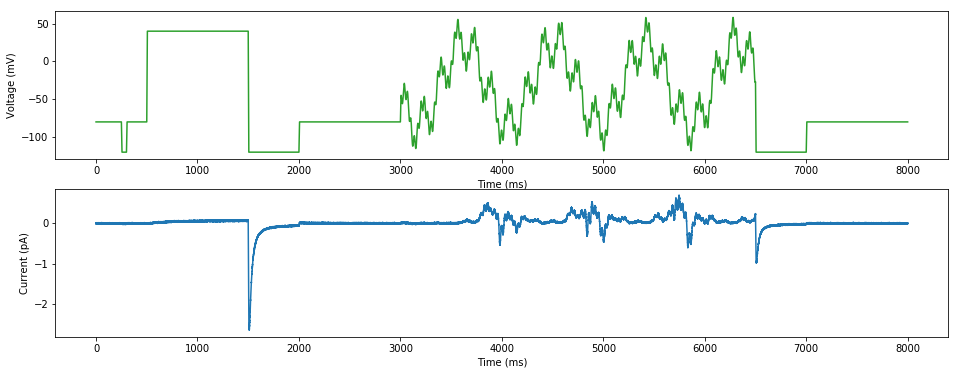

In [38]:
import myokit
import matplotlib.pyplot as plt

log = myokit.DataLog.load('resources/sine-wave-data/cell-1-filtered.zip').npview()

plt.figure(figsize=(16, 6))
plt.subplot(2, 1, 1)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.plot(log.time(), log['voltage'], color='tab:green')
plt.subplot(2, 1, 2)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(log.time(), log['current'])
plt.show()

This protocol has a peak current of approximately $-2.5\text{pA}$ at around $t_\text{peak} \approx 1500\text{ms}$, when $V = -120\text{mV}$.
From the temperature and concentrations used in recording, we can estimate $E \approx -88.4$ (see section B1.2 of the supplement for Beattie et al.).

Using $I = g_\text{max} \cdot a \cdot r \cdot (V - E)$ that gives us an estimate for $ g_\text{max} \cdot a(t_\text{peak}) \cdot r(t_\text{peak})$ of approximately:

In [42]:
-2.5 / (-120 + 88.4)

0.07911392405063293

Since $a$ and $r$ both have an upper limit of 1, that gives us a lower limit for $g_\text{max}$ in this cell of $g_\text{max} \geq 0.079 \mu\text{S}$.

The supplement to the Beattie paper (section B2.3) suggests a slightly more complicated way to estimate a lower bound, by fitting a single exponential to the _slowly decaying part_ of the current after the peak, and using its peak as an estimate of the maximum current:

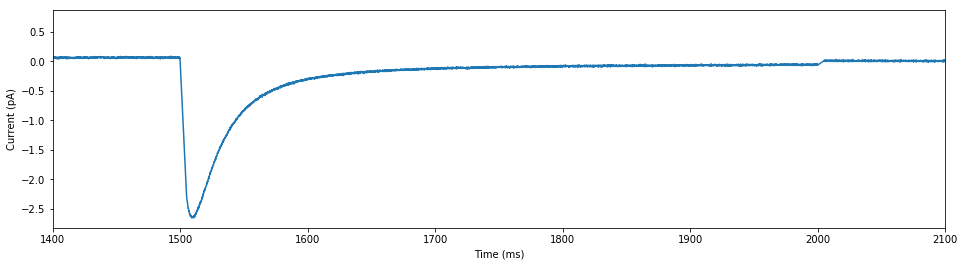

In [71]:
import numpy as np

# Select just time can current from the log
times = log.time()
currents = log['current']

# Zoom in on the peak near t=1500s
plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, currents)
plt.xlim(1400, 2100)
plt.show()

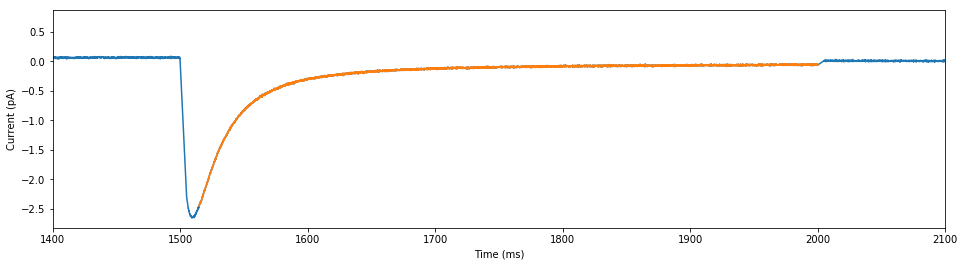

In [78]:
# Find the approximate indices where the current is decaying
i1 = np.where(log['time'] >= 1515)[0][0]
i2 = np.where(log['time'] >= 2000)[0][0]

# Show the decaying part of the current
plt.figure(figsize=(16, 4))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, currents)
plt.plot(times[i1:i2], currents[i1:i2])
plt.xlim(1400, 2100)
plt.show()

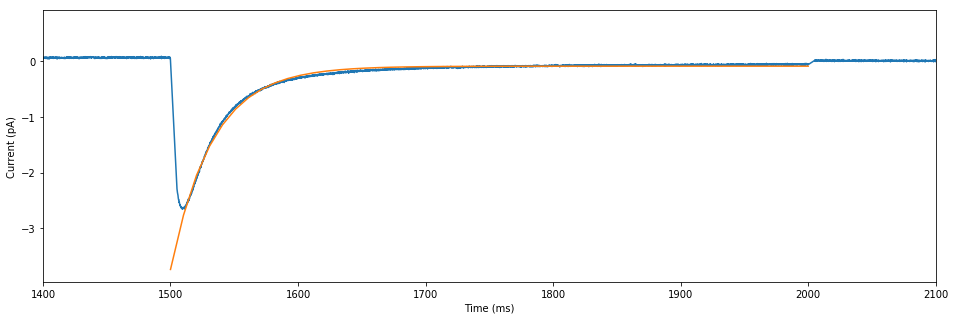

-3.73815201961526


In [117]:
# Select the decaying part
tfit = times[i1:i2] - 1500
ifit = currents[i1:i2]

# Fit a single exponential using scipy
import scipy.optimize
f = lambda t, a, b, c: a + b * np.exp(c * t)
xopt, _ = scipy.optimize.curve_fit(f, tfit, ifit, p0=[-0.1, -1, -0.1])
a, b, c = xopt

# Show the fit
tfit = np.linspace(1500, 2000)
ifit = f(tfit - 1500, a, b, c)

plt.figure(figsize=(16, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.plot(times, currents)
plt.plot(tfit, ifit)
plt.xlim(1400, 2100)
plt.show()

# Show value of the extrapolation at t=1500:
print(a + b)

In [116]:
print(a + b)

-3.73815201961526


In [118]:
(a + b) / (-120 + 88.4)

0.11829594998782471

### Limits on the "b" parameters $p_2, p_3, p_5, p_7$



In the [introduction](introduction.ipynb), we also looked at $a_i$ and $b_i$, and decided that:

- the $a_i$ parameters are positive, with the same units and roughly the same magnitude as the overal rates $k_i$
- the $b_i$ parameters are (defined to be) positive, and if we use $V$ in mV, they are most likely small: $0 \leq b_i < 1$.




### Guessing limits on the a-parameters

The $a_i$-parameters will have roughly the same order of magnitude as the rate coefficients $k_i$, so if we can get a feeling for what the rate coefficients mean, we might be able to [make some guesses about sensible numbers](https://what-if.xkcd.com/84/).








\begin{align}
\frac{da}{dt} = \frac{a - a_\infty}{\tau_a} &&& a_\infty = \frac{k1}{k1 + k2} &&& \tau_a = \frac{1}{k_1 + k_2}
\end{align}

and solve for a fixed $V$ to find
\begin{align}
a(t, V=V_\text{fixed}) = a_\infty + (a_0 - a_\infty) e^{-t/\tau_a}
\end{align}

which is an [exponential decay](https://en.wikipedia.org/wiki/Exponential_decay) process with a [half-life](https://en.wikipedia.org/wiki/Half-life) of 
$$t_{1/2} = \tau_a \ln(2) = \frac{\ln(2)}{k_1 + k_2}$$

Assuming that $k_1$ is of the same order of magnitude as $k_2$,


We could start by looking at the units.
If we choose time in _ms_ (which seems to be sensible for ion channels), we get a rate in _1/ms_.
So if we assume the underlying processes are on the same scale as the overal behaviour we could draw up some bounds around _1 (1/ms)_, say $k_i \in [10^{-3} (1/\text{ms}), 10^3 \text{ms}]$.


## Basing boundaries on previous data

We could also try looking at some previous data for the channel we're trying to esimate.
For example, the graph below shows some data digitized from figure 13a of [hERG K+ Channels: Structure, Function, and Clinical Significance](https://journals.physiology.org/doi/full/10.1152/physrev.00036.2011), by Jamie Vandenberg et al.:


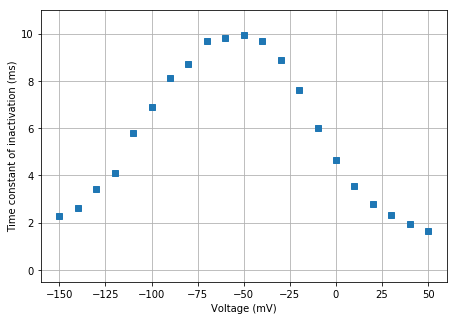

In [6]:
import numpy as np
import matplotlib.pyplot as plt

voltage = np.arange(-150, 60, 10)
tau_r = np.array([
    2.2966, 2.6435, 3.4241, 4.1006, 5.7832, 6.876, 8.1422, 
    8.6973, 9.686, 9.8075, 9.9289, 9.6687, 8.9055, 7.6219,
    6.026, 4.673, 3.5455, 2.7954, 2.314, 1.9366, 1.6548])

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.xlabel('Voltage (mV)')
plt.ylabel('Time constant of inactivation (ms)')
plt.plot(voltage, tau_r, 's')
plt.xlim(-160, 60)
plt.ylim(-0.5, 11)
plt.grid(True)
plt.show()

Next, Vandenberg et al. make some great observations:
First, they define $k_\text{observed} = k_3 + k_4 = 1 / \tau_r$, and plot this on a semi-log scale:

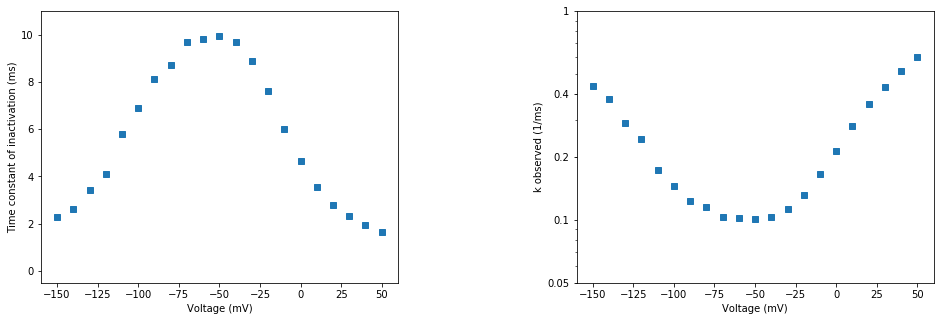

In [7]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.xlabel('Voltage (mV)')
plt.ylabel('Time constant of inactivation (ms)')
plt.plot(voltage, tau_r, 's')
plt.xlim(-160, 60)
plt.ylim(-0.5, 11)

ax = plt.subplot(1, 2, 2)
plt.semilogy()
plt.xlabel('Voltage (mV)')
plt.ylabel('k observed (1/ms)')
plt.plot(voltage, 1 / tau_r, 's')
plt.xlim(-160, 60)
plt.ylim(5e-2, 1)
ax.set_yticks([5e-2, 1e-1, 2e-1, 4e-1, 1])
ax.set_yticklabels([5e-2, 1e-1, 2e-1, 4e-1, 1])

plt.subplots_adjust(wspace=0.5)
plt.show()

- It seems that there's plenty of voltage sensitivity
- Since $k_\text{observered} = k_3 + k_4 = a_3 e^{+b_3 V} + a_4 e^{-b_4 V}$, we can assume that the points on the far right (where $V$ is very positive) are dominated by $k_3$ (the rate of inactivation), while points on the far left (where $V$ is very negative) are dominated by $k_4$ (the rate of recovery).
- So we can fit lines to these points, and use them to estimate the $a$'s and $b$'s

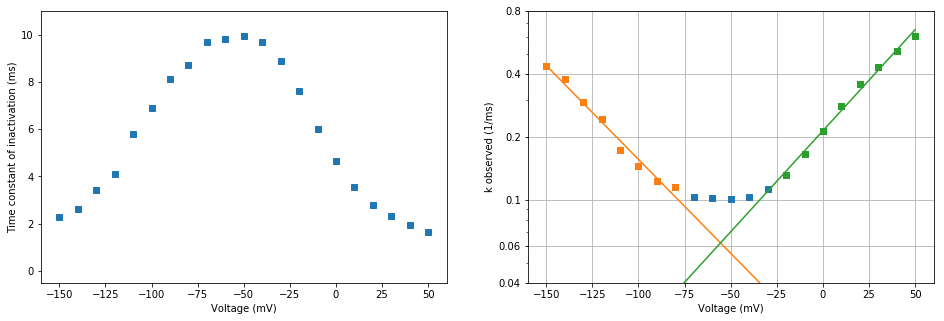

Esimates:
a3: 0.2138594262779559
b3: 0.022277787488105823
a4: 0.019680009317219783
b4: 0.02069200269754123


In [31]:
# Log of k observed
logk = np.log(1 / tau_r)

# Left: rate of recovery k_4 = a_4 e^(b_4 V)
n4 = 8
b4, log_a4 = np.polyfit(voltage[:n4], logk[:n4], 1)
a4 = np.exp(log_a4)
k4 = a4 * np.exp(b4 * voltage)

# Right: rate of recovery k_4 = a_4 e^(b_4 V)
n3 = -8
b3, log_a3 = np.polyfit(voltage[n3:], logk[n3:], 1)
a3 = np.exp(log_a3)
k3 = a3 * np.exp(b3 * voltage)

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.xlabel('Voltage (mV)')
plt.ylabel('Time constant of inactivation (ms)')
plt.plot(voltage, tau_r, 's')
plt.xlim(-160, 60)
plt.ylim(-0.5, 11)

ax = plt.subplot(1, 2, 2)
plt.semilogy()
plt.xlabel('Voltage (mV)')
plt.ylabel('k observed (1/ms)')
plt.plot(voltage, 1 / tau_r, 's')
plt.plot(voltage[:n4], 1 / tau_r[:n4], 's', color='tab:orange')
plt.plot(voltage, k4, color='tab:orange')
plt.plot(voltage[n3:], 1 / tau_r[n3:], 's', color='tab:green')
plt.plot(voltage, k3, color='tab:green')
plt.xlim(-160, 60)
plt.ylim(4e-2, 0.6)
ax.set_yticks([0.04, 0.06, 0.1, 0.2, 0.4, 0.8])
ax.set_yticklabels([4e-2, 0.06, 0.1, 0.2, 0.4, 0.8])
plt.grid(True)

plt.show()

print('Esimates:')
print('a3: ' + str(a3))
print('b3: ' + str(b3))
print('a4: ' + str(a4))
print('b4: ' + str(-b4))

While this is an approximation, and only one experiment, it gives us an idea of the _expected magnitude_ for the parameters for inactivation/recovery: $a \approx 10^{-1}$, $b \approx 10^{-2}$.

## Using boundaries in an optimisation

TODO: Example with simple rectangular boundaries

## Setting boundaries on rates

## Summary

In this part of the tutorial, we have

- Lalala

In the next part